## Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from tsfresh import extract_features
from tsfresh import select_features
import lightgbm as lgb
from sklearn.model_selection import train_test_split,GroupKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm


In [2]:
df = pl.read_parquet('data/train_dataset_feature_selected.parquet').to_pandas()

In [3]:
df.series_id.unique()

array(['0402a003dae9', '0a96f4993bd7', '0ec9fc461819', '0f572d690310',
       '137771d19ca2', '2b8d87addea9', '3318a0e3ed6f', '3452b878e596',
       '349c5562ee2c', '361366da569e', '3be1545083b7', '3d53bfea61d6',
       '3df0da2e5966', '416354edd92a', '44a41bba1ee7', '4743bdde25df',
       '483d6545417f', '5f94bb3e1bed', '653622ac8363', '6a4cd123bd69',
       '702bb5387b1e', '72ba4a8afff4', '72bbd1ac3edf', '89bd631d1769',
       '91127c2b0e60', '939932f1822d', '99b829cbad2d', 'a9e5f5314bcb',
       'aa81faa78747', 'ad425f3ee76d', 'bccf2f2819f8', 'bdfce9ce62b9',
       'bfa54bd26187', 'ccdee561ee5d', 'ce9164297046', 'cfeb11428dd7',
       'd515236bdeec', 'd93b0c7de16b', 'e2b60820c325', 'fbf33b1a2c10'],
      dtype=object)

In [4]:
to_keep = ['72ba4a8afff4','939932f1822d','ce9164297046','ccdee561ee5d','d515236bdeec','91127c2b0e60','483d6545417f']
subset = df[df['series_id'].isin(to_keep)]


In [5]:
y = subset['state']
onset = subset['onset']
wakeup = subset['wakeup']
groups = subset['series_id']
X = subset.drop(columns=['state','onset','wakeup','step','series_id'])

<Axes: xlabel='series_id'>

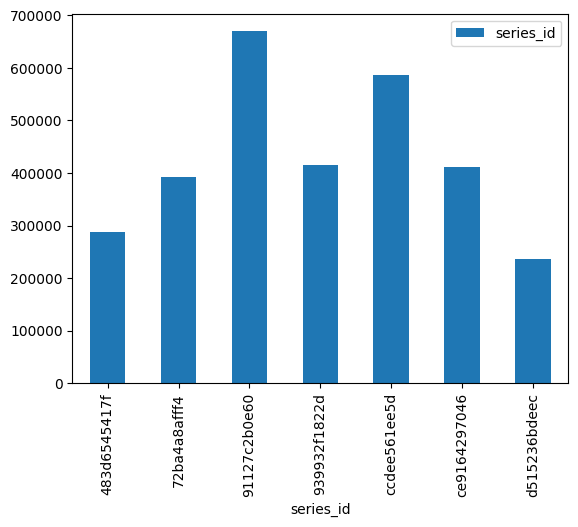

In [6]:
subset.groupby('series_id').agg({'series_id':'count'}).plot.bar()

## Mix them UP

**RandomForest**


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [8]:

# # Initialize GroupKFold
# gkf = GroupKFold(n_splits=5)

# # Split the data using GroupKFold
# for train_index, test_index in gkf.split(X, y, groups):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9995162119058582

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    437595
           1       1.00      1.00      1.00    161841

    accuracy                           1.00    599436
   macro avg       1.00      1.00      1.00    599436
weighted avg       1.00      1.00      1.00    599436



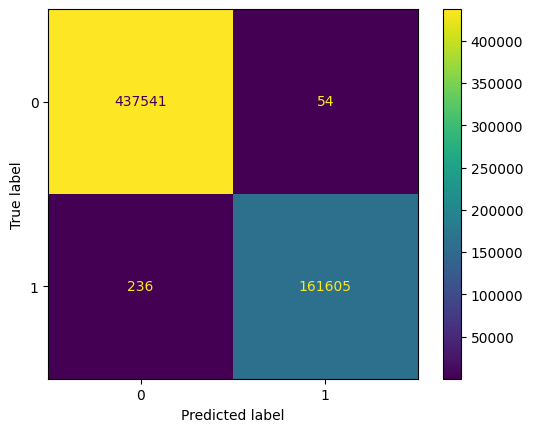

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

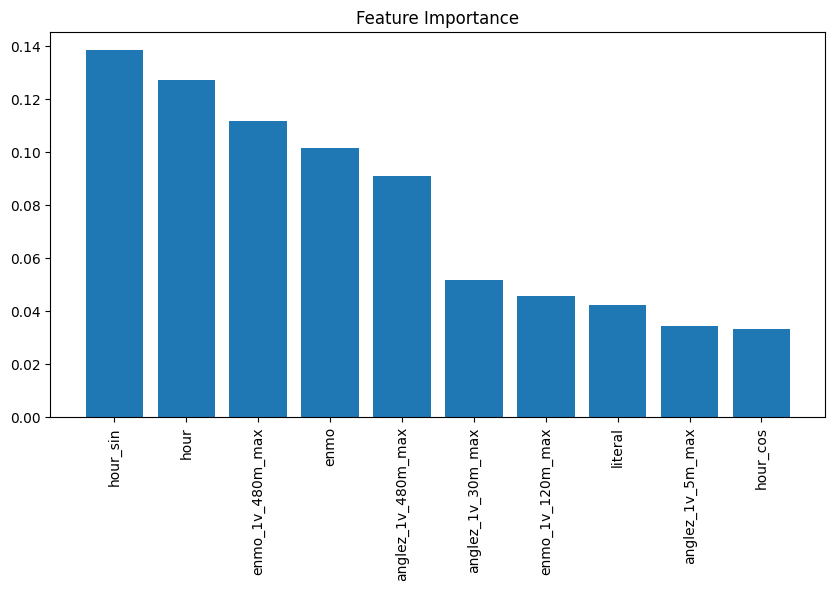

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'clf' is your trained model and 'X' is your feature set

# Display the 10 most important features
number = 10
importances = clf.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Select the indices of the top 'number' important features
top_indices = indices[:number]

# Get the names of the top 'number' important features
names = [X.columns[i] for i in top_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.title("Feature Importance")
plt.bar(range(number), importances[top_indices])
plt.xticks(range(number), names, rotation=90)
plt.show()


**LGBM**

In [13]:
import lightgbm as lgb
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [14]:

# Define parameters
params = {
    'objective': 'binary',  # or 'multiclass' if you have more than two classes
    'metric': 'binary_logloss',  # or 'multi_logloss' for multiclass
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 23,  # Adjust based on your machine's capability
    "histogram_pool_size": 1024,  # Adjust based on your machine's capability
    "max_bin": 255,  # Adjust based on your machine's capability
}


In [15]:
try:
    # Train the model
    lgbm_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000)
except Exception as e:
    print(e)
    print('Error in training. Check your parameters.')



In [16]:
# Predict on the test set
y_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Convert probabilities to binary output
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9963348881281738


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    437595
           1       0.99      0.99      0.99    161841

    accuracy                           1.00    599436
   macro avg       1.00      1.00      1.00    599436
weighted avg       1.00      1.00      1.00    599436



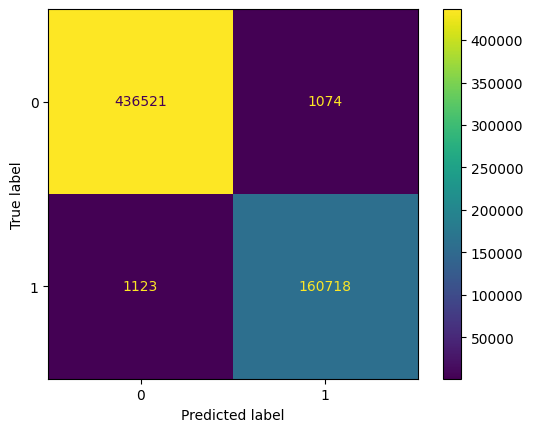

In [17]:
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(classification_report(y_test, y_pred_binary))

## Predictions

In [42]:
to_test = ['0a96f4993bd7'] #+ ['3df0da2e5966']
test_subset = df[df['series_id'].isin(to_test)]


In [43]:
y_test = test_subset['state']
onset = test_subset['onset']
wakeup = test_subset['wakeup']

y_pred_rf = clf.predict(test_subset.drop(columns=['state','onset','wakeup','step','series_id']))
y_pred_lgbm_proba = lgbm_model.predict(test_subset.drop(columns=['state','onset','wakeup','step','series_id']), num_iteration=lgbm_model.best_iteration)
y_pred_lgbm = [1 if x > 0.5 else 0 for x in y_pred_lgbm_proba]

              precision    recall  f1-score   support

           0       0.93      0.97      0.95    157968
           1       0.95      0.88      0.91     98892

    accuracy                           0.93    256860
   macro avg       0.94      0.92      0.93    256860
weighted avg       0.93      0.93      0.93    256860



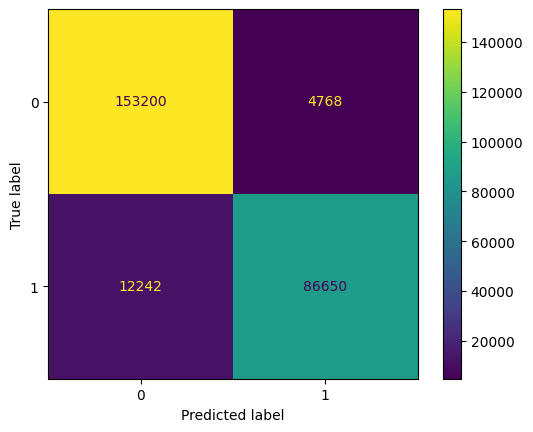

In [44]:
cm = confusion_matrix(y_test, y_pred_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    157968
           1       0.96      0.91      0.93     98892

    accuracy                           0.95    256860
   macro avg       0.95      0.94      0.95    256860
weighted avg       0.95      0.95      0.95    256860



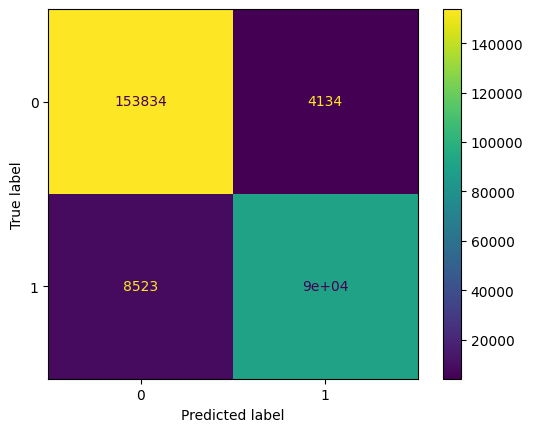

In [45]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(classification_report(y_test, y_pred_rf))

In [70]:
def detect_transition(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    diff = np.diff(y_pred)
    onsets = np.where(diff == 1)
    wakeups = np.where(diff == -1)
    return onsets, wakeups

In [90]:
pred_onset, pred_wakeup = detect_transition(y_test, y_pred_rf)

pred_onset += test_subset.step.min()
pred_wakeup += test_subset.step.min()

In [92]:
def plot_signals(
    serie: str, df, ax: plt.Axes
) -> plt.Axes:
    """
    Plot signals for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_signals : pl.DataFrame
        DataFrame containing the columns 'series_id', 'timestamp', 'anglez', 'enmo'
    """
    data = df[df["series_id"] == serie]
    sns.lineplot(
        data=df[::100], x="step", y="anglez", alpha=0.5, ax=ax,hue='state'
    )
    sns.lineplot(data=df[::100], x="step", y="enmo", alpha=0.5,ax=ax)
    ax.set_title(f"Signals for {serie}")

    return ax

In [93]:
def plot_transitions(onsets, wakeups, ax):
    for onset in onsets:
        ax.axvline(onset, color="blue", linestyle="--", alpha=0.5)
    for wakeup in wakeups:
        ax.axvline(wakeup, color="red", linestyle="--", alpha=0.5)
    return ax

<Axes: title={'center': 'Signals for 0a96f4993bd7'}, xlabel='step', ylabel='anglez'>

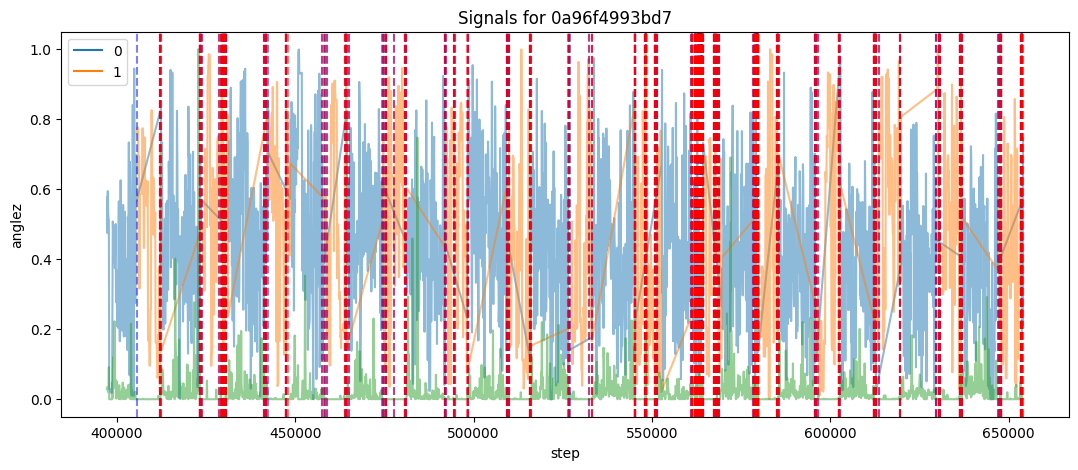

In [94]:
_, ax = plt.subplots(figsize=(13, 5))
plot_signals("0a96f4993bd7", test_subset, ax)
plot_transitions(pred_onset[0], pred_wakeup[0], ax)

In [95]:
pred_onset, pred_wakeup = detect_transition(y_test, y_pred_lgbm)

pred_onset += test_subset.step.min()
pred_wakeup += test_subset.step.min()

<Axes: title={'center': 'Signals for 0a96f4993bd7'}, xlabel='step', ylabel='anglez'>

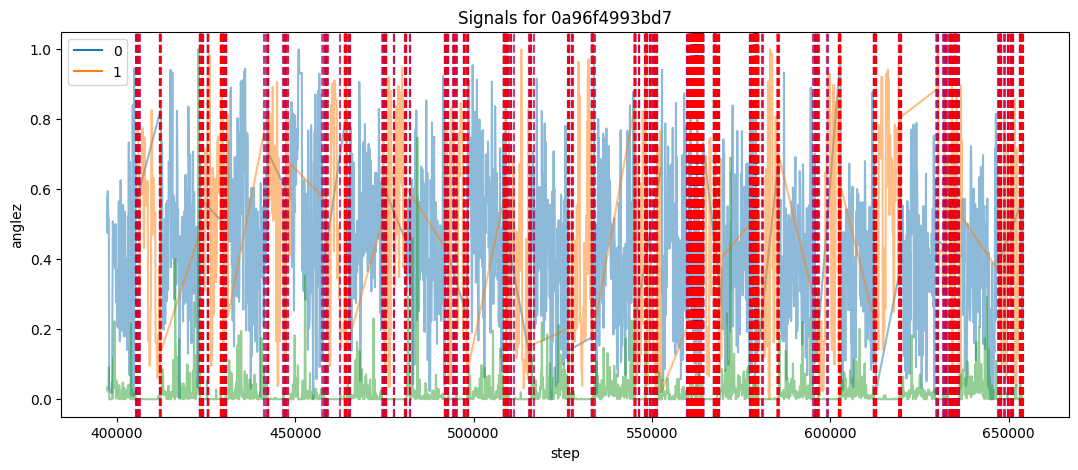

In [96]:
_, ax = plt.subplots(figsize=(13, 5))
plot_signals("0a96f4993bd7", test_subset, ax)
plot_transitions(pred_onset[0], pred_wakeup[0], ax)